This code solves the 'time since infection' model described in our recent report [arxiv link when available].

$\frac{dS}{dt} = -R_0S\int_{-1}^{1}\beta(s)I(t,s)ds$

$\frac{\partial I}{\partial t} + \frac{\partial I}{\partial s} = 0$

$I(t,-1) = -\frac{dS}{dt}$

This code also considers the generalization to age-structured models and allows for an arbitrary number of sub-classes to the infected population with arbitrary time-dependent probabilities for entering/leaving those sub-classes

In [1]:
%%capture
## compile PyRossTSI for this notebook
import os
owd = os.getcwd()
os.chdir('../..')
%run setup.py install
os.chdir(owd)

import pyrosstsi
import numpy as np
import matplotlib.pyplot as plt

In [2]:
T = 15       #What's the longest time (in days) for which a person can be infectious?
Td = 5       #What's the doubling time (in days) when in the linear growth regime?
Tf = 150     #End time (days)

tsi  = np.array([0,   3,    5,   10,   T])   #time since infection (days)
beta = np.array([0,   0.5,  1,   .5,   0])   #mean infectiousness (arbitrary units)
tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])  #For convenience, we say that you reach your final state at time T
                                                              #if this is not OK, adjust previous section accordingly
    
  

In [3]:
M = 2                   #Number of age groups to model
Ni = 10**6*np.ones(M)   #Number of people in each age group
Np = sum(Ni)            #total population size

In [4]:
subclasses = ['Recovered', 'Hospitalized', 'Deceased'] #e.g. Recovered, Hospitalized, Deceased
method='Predictor_Corrector'  # Galerkin and Hybrid also possible
integrator='odeint'
Nc = len(subclasses)


In [5]:
#Specify the level of resolution in the s-direction
NL = 6     #Number of Legendre Polynomials for the Galerkin method (when applicable)
Nk = 10    #Number of stages in Predictor/Corrector method

Tc = T/2 #rescaling of time, and tsi
tswap = np.array([0, 5*T/2]); tswap = np.append(tswap/Tc, Tf)

In [6]:
def Cij_dim(t):    return np.array([[4, 1],[1, 2]]); 
Cij = Cij_dim(0)

A = np.matmul(np.diag(Ni),Cij);  A = np.matmul(A,np.diag(1/Ni)); max_eig_A = np.max(np.real(np.linalg.eigvals(A)))

sp = np.linspace(0,T,1000); lam = np.log(2)/Td;  #Growth rate
rs = max_eig_A*np.trapz(np.exp(-lam*sp)*np.interp(sp,tsi,beta),sp)
beta = beta/rs       #now beta has been rescaled to give the correct (dimensional) doubling time

#define a rescaled tsi
s = np.linspace(-1,1,Nk)

#next make sure that the initial condition is known
def get_IC(ep):
    #Initial susceptible is the whole population
    S_0 = Ni

    #get contact matrix from frist time step
    Cij = Cij_dim(0)

    #get I_0 from linear stability analysis
    #find the fastest growing linear mode
    A = np.matmul(np.diag(Ni),Cij)
    A = np.matmul(A,np.diag(1/Ni))
    sp = np.linspace(0,T,1000)
    lam = np.log(2)/Td;
    A = A*np.trapz(np.exp(-lam*sp)*np.interp(sp,tsi,beta),sp)
    w, v = np.linalg.eig(-np.identity(M) + A)

    #now identify the largest eigenvalue/eigenvector...
    pos = np.where(w == np.amax(w))
    pos = pos[0][0]
    lam = T/Td*np.log(2)
    s = np.linspace(-1,1,Nk)
    I_0 = ep*np.abs(np.real(np.outer(np.exp(-lam*s),v[:,pos])))

    #just set Ic_0 to zero -- these numbers are too small to matter
    Ic_0 = np.zeros((Nc,M))

    return S_0, I_0, Ic_0

S_0, I_0, Ic_0 = get_IC(10**-3/T*Np)

#rescale all population sizes
Ni = Ni/Np
I_0 = I_0/Np*Tc  #recall that this is a number density (number infected per unit tsi)
S_0 = S_0/Np
Ic_0 = Ic_0/Np*Tc

#precompute Cij/Nj as a rescaled contact matrix:
def Cij_t(t):
    return np.matmul(Cij_dim(t*Tc),np.diag(1/Ni))

#nondimensionalize beta:
beta = beta*Tc
tsi = tsi/Tc - 1
tsi_sc = tsi_sc/Tc - 1

#rescale end time
Tf = Tf/Tc
IC = [S_0, I_0, Ic_0]

tswap = np.append(tswap/Tc, Tf)

params = {'M':M, 'Nc':Nc, 'Nk':Nk, 'Tf':Tf, 'Tc':Tc, 'T':T, 'NL':NL,
          'tsi':tsi,'beta':beta, 'tswap':tswap,
          'tsi_sc':tsi_sc}

In [16]:
method ='Predictor_Corrector'; integrator='odeint'
model  = pyrosstsi.deterministic.Simulator(params, IC, subclasses, method, integrator)

data = model.integrate(Cij_t)

In [17]:
t = data['t']
S_t = data['S_t']
I_t = data['I_t']
Ic_t = data['Ic_t']

(0.0, 498.49353066494547)

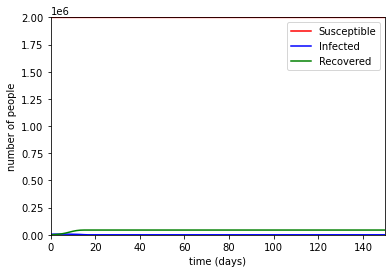

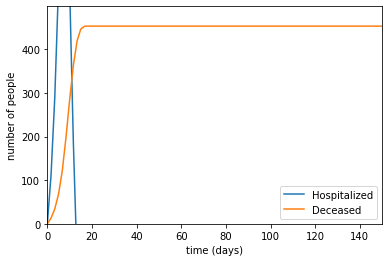

In [18]:
plt.figure()    
plt.plot(t*Tc,Np*np.sum(S_t,0),'r', label = 'Susceptible')           #all susceptible
plt.plot(t*Tc,Np*np.sum(I_t,0),'b', label = 'Infected')              #all Infected
plt.plot(t*Tc,Np*np.sum(Ic_t[0,:,:],0),'g', label = subclasses[0])   #all recovered
plt.legend()
plt.xlabel('time (days)');       plt.xlim(0,Tf*Tc)
plt.ylabel('number of people');  plt.ylim(0,Np)

#Other subclasses of Infected:
plt.figure() 
for i in (1 + np.arange(Nc-1)):
    plt.plot(Tc*t,Np*np.sum(Ic_t[i,:,:],0), label = subclasses[i])
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('number of people')
plt.xlabel('time (days)');       plt.xlim(0,Tf*Tc)
plt.ylabel('number of people');  plt.ylim(0,1.1*np.amax(Np*np.sum(Ic_t[2,:,:],0)))